In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import matplotlib.pyplot as plt
import torch 
from torch import nn
torch.set_default_dtype(torch.float64)
import torch.nn.functional as func

import copy
from tqdm.notebook import tqdm
import time
import random
import seaborn as sns
sns.set_theme()

from sklearn.neighbors import NearestNeighbors
from scipy.interpolate import griddata
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import euclidean_distances
from IPython.display import clear_output

In [2]:
plt.rcParams['text.usetex'] = True

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import sys; sys.path.insert(1, '../')
from committor_lib.Example3 import Solvated_dimer,Model,Solver
from committor_lib.utils    import rL2,LangevinIntegrator,Metadynamics,Metadynamics_Extend

# The system

In [4]:
# n_atoms = 32; L = 64**(1/3); density is 0.5

SYS      = Solvated_dimer(n_atoms=32,L=64**(1/3),h=5,w=0.25,r0=2**(1/6),eps=1,rWCA=2**(1/6),); EPS = 1;
get_x_bc = SYS.get_X_bc
LI       = LangevinIntegrator(dim=SYS.dim)

# Read some data

In [5]:
# By simulating the Langevin dynamics
X_A,X_B = np.loadtxt('X_A'),np.loadtxt('X_B')
# By Monte Carlo methods
X_u,q_u = np.loadtxt('X_u'),np.loadtxt('q_u')
print(X_A.shape,X_B.shape,X_u.shape,q_u.shape);
def Error_Model(model): return rL2(q_u,model.get_q(X_u))
def E_AB(model): return np.sqrt(np.mean(model.get_q(X_A)**2))+np.sqrt(np.mean((1-model.get_q(X_B))**2))

(2000, 96) (2000, 96) (1574, 96) (1574,)


In [6]:
def Estimate_Model(model,X_u=X_u,q_u=q_u,SYS=SYS):
    fig,ax = plt.subplots(1,2,figsize=(12,5))
    q_NN = model.get_q(X_u)
    ax[0].scatter(SYS.get_bond_length(X_u),q_NN,s=5.,label='100 states')
    ax[1].scatter(SYS.get_bond_length(X_u),q_u,s=5.,c='g',label='100 states')
    ax[0].set_title('NN: %.3f'%rL2(q_u,q_NN))
    ax[1].set_title('MC')
    for i in range(2):
        ax[i].set_xlabel('bond length',fontsize=13)
        ax[i].set_ylabel('$q$',fontsize=13,rotation=0)
        ax[i].set_xlim([SYS.r0,SYS.r0+2*SYS.w])
        ax[i].set_ylim([-.1,1.1])
        ax[i].legend(fontsize=13)
    plt.show()

# Set the model

In [7]:
def get_wrapvec(x,L=SYS.L): return x-torch.round(x/L)*L

n           = 10
rbf_centers = torch.tensor(np.linspace(0,SYS.L/2*np.sqrt(3)+1,100)).cuda()
rbf_gap     = (rbf_centers[1]-rbf_centers[0])**2*10
model       = Model(get_wrapvec=get_wrapvec,rbf_centers=rbf_centers,rbf_gap=rbf_gap,
                    n_atoms=SYS.n_atoms,input_dim=SYS.dim,n_fea=32,n_interactions=2,n=n).cuda()
solver      = Solver(model,unit_len=100,q0=-5,q1=5)

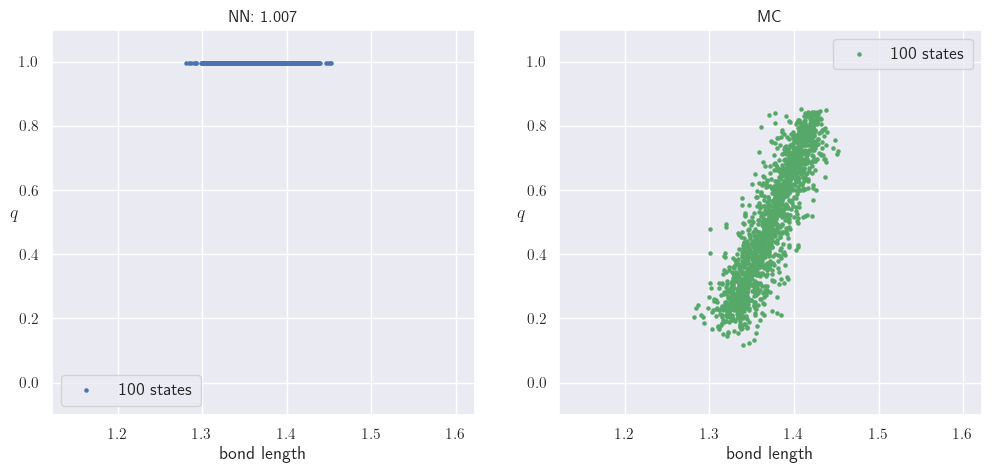

In [9]:
Estimate_Model(model,X_u=X_u,q_u=q_u,SYS=SYS)

In [10]:
data_train = [[],torch.tensor(X_A).cuda(),torch.tensor(X_B).cuda()]
data_test  = [[],torch.tensor(X_A).cuda(),torch.tensor(X_B).cuda()]
optimizer = torch.optim.Adam(model.parameters(),lr=torch.tensor(1e-3).cuda())

def terminal_condition(model): return E_AB(model)<1e-2
solver.train_model(data_train=data_train,data_test=data_test,c1=0,c2=1,batch_size=100,
                   optimizer=optimizer,n_steps=int(2e3+1),n_show_loss=100,terminal_condition=terminal_condition,
                   error_model1=Error_Model,error_model2=E_AB,use_tqdm=True);
torch.save(model.state_dict(), '../saved_models/E3_Random1')

  0%|          | 0/2001 [00:00<?, ?it/s]

 0k, Loss: -1.00000, -1.00000, Error: 1.00140 1.00004
 0k, Loss: -1.00000, -1.00000, Error: 0.35300 0.99487
 0k, Loss: -1.00000, -1.00000, Error: 0.72555 0.87411
 0k, Loss: -1.00000, -1.00000, Error: 0.87509 0.05271
 0k, Loss: -1.00000, -1.00000, Error: 0.91446 0.02985
 0k, Loss: -1.00000, -1.00000, Error: 0.90108 0.01819
 0k, Loss: -1.00000, -1.00000, Error: 0.89570 0.01090


In [10]:
torch.cuda.empty_cache()

# Train

In [12]:
def show_distr(X,ax,get_phi=SYS.get_bond_length):
    bond_length = get_phi(X)
    ax.hist(bond_length,25)
    ax.axvline(SYS.r0,linestyle='--',linewidth=3,color='r')
    ax.axvline(SYS.r0+2*SYS.w,linestyle='--',linewidth=3,color='r')
    ax.set_xlabel('bond length')
    ax.set_title('shape:'+str(X.shape))

In [13]:
def down_sample(X):
    mask = SYS.IsInA(X) | SYS.IsInB(X)
    return X[~mask]
def get_train_test(X,coef,X_A,X_B,ratio=0.7):
    Xc         = np.hstack([X,coef.reshape(-1,1)])
    data_train = []
    data_test  = []
    for d,requires_grad in [[Xc,True],[X_A,False],[X_B,False]]:
        perm = np.random.permutation(len(d))
        d1 = d[perm[:int(len(d)*ratio)]]
        data_train.append(torch.tensor(d1,requires_grad=requires_grad).cuda())
        d2 = d[perm[int(len(d)*ratio):]]
        data_test.append(torch.tensor(d2,requires_grad=requires_grad).cuda())
    return data_train,data_test 

In [14]:
NAME = 'ABC1'
if not os.path.isdir('../saved_models/'+NAME+'/'): os.mkdir('../saved_models/'+NAME+'/')
if not os.path.isdir('../meta_data/'+NAME+'/'): os.mkdir('../meta_data/'+NAME+'/')

In [15]:
def get_wrapvec(x,L=SYS.L): return x-torch.round(x/L)*L

n           = 10
rbf_centers = torch.tensor(np.linspace(0,SYS.L/2*np.sqrt(3)+1,100)).cuda()
rbf_gap     = (rbf_centers[1]-rbf_centers[0])**2*10
model       = Model(get_wrapvec=get_wrapvec,rbf_centers=rbf_centers,rbf_gap=rbf_gap,
                    n_atoms=SYS.n_atoms,input_dim=SYS.dim,n_fea=32,n_interactions=2,n=n).cuda()
solver      = Solver(model,unit_len=100,q0=-5,q1=5)

meta = Metadynamics(model=model,h=.1,w=.003)

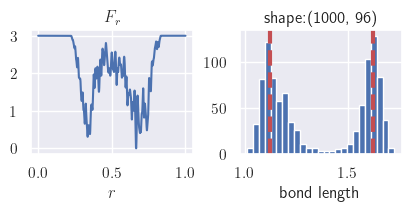

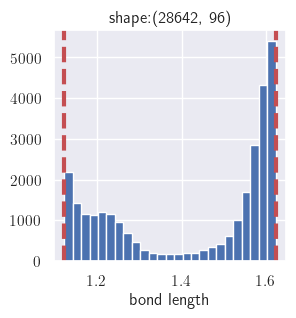

torch.Size([28355, 97]) torch.Size([287, 97])
torch.Size([1980, 96]) torch.Size([20, 96])
torch.Size([1980, 96]) torch.Size([20, 96])
 0k, Loss: -1.00000, -1.00000, Error: 0.92527 9.78e-03
 0k, Loss: -1.00000, -1.00000, Error: 0.34624 0.02179
 1k, Loss: -1.00000, -1.00000, Error: 0.27605 0.01713
 1k, Loss: -1.00000, -1.00000, Error: 0.26533 0.01500
 2k, Loss: -1.00000, -1.00000, Error: 0.24692 0.01403
 2k, Loss: -1.00000, -1.00000, Error: 0.21236 0.01328
 3k, Loss: -1.00000, -1.00000, Error: 0.20530 0.01329
 3k, Loss: -1.00000, -1.00000, Error: 0.18596 0.01512
 4k, Loss: -1.00000, -1.00000, Error: 0.18170 0.01288
 4k, Loss: -1.00000, -1.00000, Error: 0.19542 0.01183
 5k, Loss: -1.00000, -1.00000, Error: 0.19927 0.01070


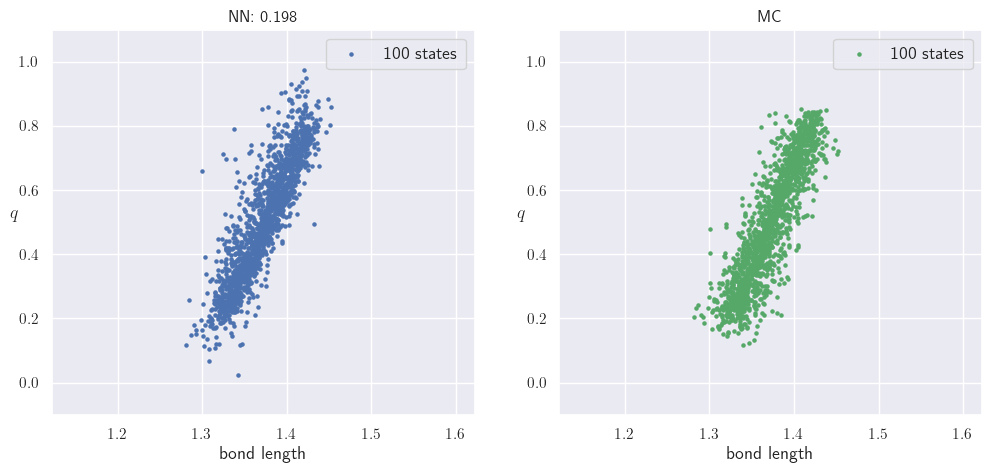

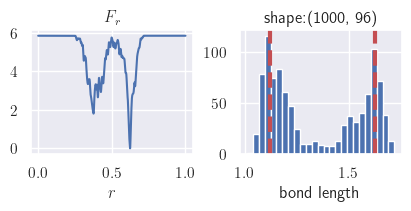

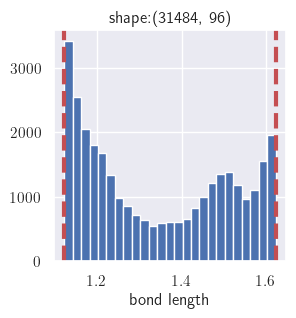

torch.Size([31169, 97]) torch.Size([315, 97])
torch.Size([1980, 96]) torch.Size([20, 96])
torch.Size([1980, 96]) torch.Size([20, 96])
 0k, Loss: -1.00000, -1.00000, Error: 0.19817 0.01060
 0k, Loss: -1.00000, -1.00000, Error: 0.17995 0.01089
 1k, Loss: -1.00000, -1.00000, Error: 0.17418 0.01016
 1k, Loss: -1.00000, -1.00000, Error: 0.16646 0.01049
 2k, Loss: -1.00000, -1.00000, Error: 0.17718 0.01070
 2k, Loss: -1.00000, -1.00000, Error: 0.15964 0.01094
 3k, Loss: -1.00000, -1.00000, Error: 0.20432 0.01128
 3k, Loss: -1.00000, -1.00000, Error: 0.19026 0.01173
 4k, Loss: -1.00000, -1.00000, Error: 0.15878 0.01099
 4k, Loss: -1.00000, -1.00000, Error: 0.19014 0.01095
 5k, Loss: -1.00000, -1.00000, Error: 0.18213 0.01177


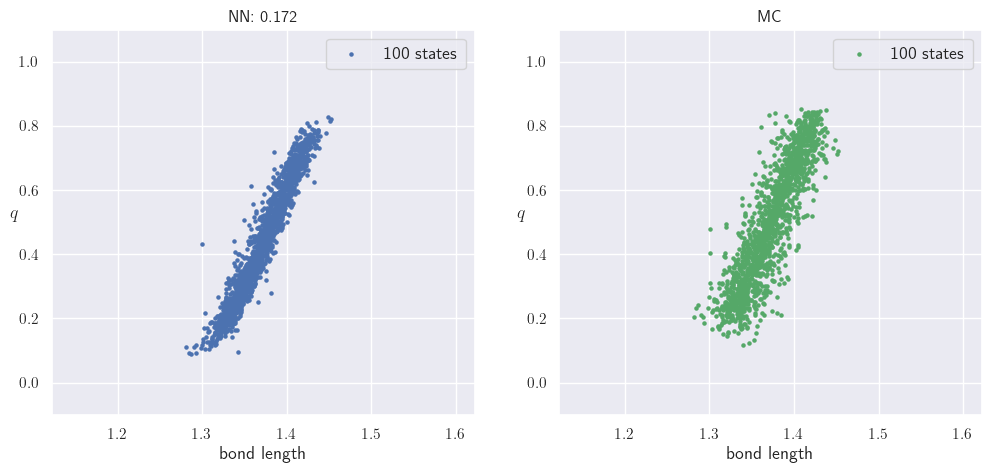

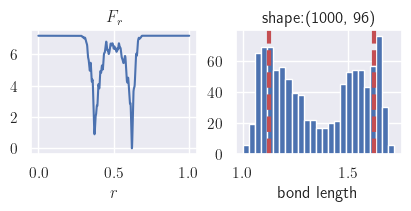

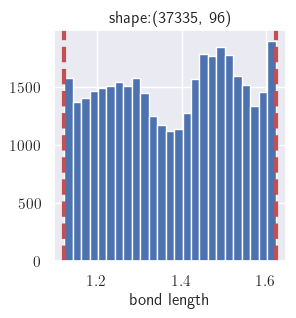

torch.Size([36961, 97]) torch.Size([374, 97])
torch.Size([1980, 96]) torch.Size([20, 96])
torch.Size([1980, 96]) torch.Size([20, 96])
 0k, Loss: -1.00000, -1.00000, Error: 0.17227 0.01168
 0k, Loss: -1.00000, -1.00000, Error: 0.14228 0.01130
 1k, Loss: -1.00000, -1.00000, Error: 0.13742 0.01114
 1k, Loss: -1.00000, -1.00000, Error: 0.13052 0.01071
 2k, Loss: -1.00000, -1.00000, Error: 0.14255 0.01110
 2k, Loss: -1.00000, -1.00000, Error: 0.15950 0.01189
 3k, Loss: -1.00000, -1.00000, Error: 0.11881 0.01146
 3k, Loss: -1.00000, -1.00000, Error: 0.15075 0.01174
 4k, Loss: -1.00000, -1.00000, Error: 0.15293 0.01138
 4k, Loss: -1.00000, -1.00000, Error: 0.10622 0.01209
 5k, Loss: -1.00000, -1.00000, Error: 0.15242 0.01203


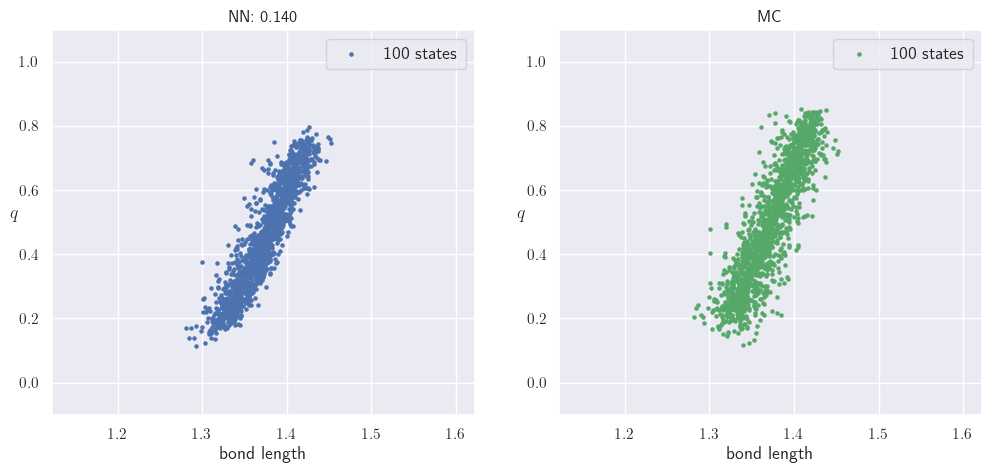

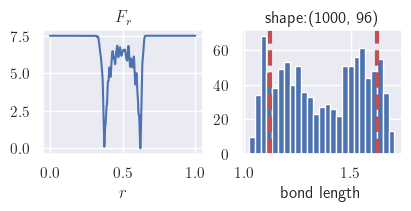

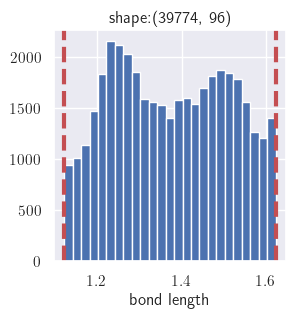

torch.Size([39376, 97]) torch.Size([398, 97])
torch.Size([1980, 96]) torch.Size([20, 96])
torch.Size([1980, 96]) torch.Size([20, 96])
 0k, Loss: -1.00000, -1.00000, Error: 0.14015 0.01194
 0k, Loss: -1.00000, -1.00000, Error: 0.10784 0.01190
 1k, Loss: -1.00000, -1.00000, Error: 0.11968 0.01208
 1k, Loss: -1.00000, -1.00000, Error: 0.11592 0.01177
 2k, Loss: -1.00000, -1.00000, Error: 0.14308 0.01170
 2k, Loss: -1.00000, -1.00000, Error: 0.13285 0.01194
 3k, Loss: -1.00000, -1.00000, Error: 0.10779 0.01178
 3k, Loss: -1.00000, -1.00000, Error: 0.14084 0.01185
 4k, Loss: -1.00000, -1.00000, Error: 0.12106 0.01187
 4k, Loss: -1.00000, -1.00000, Error: 0.12146 0.01185
 5k, Loss: -1.00000, -1.00000, Error: 0.09596 0.01167


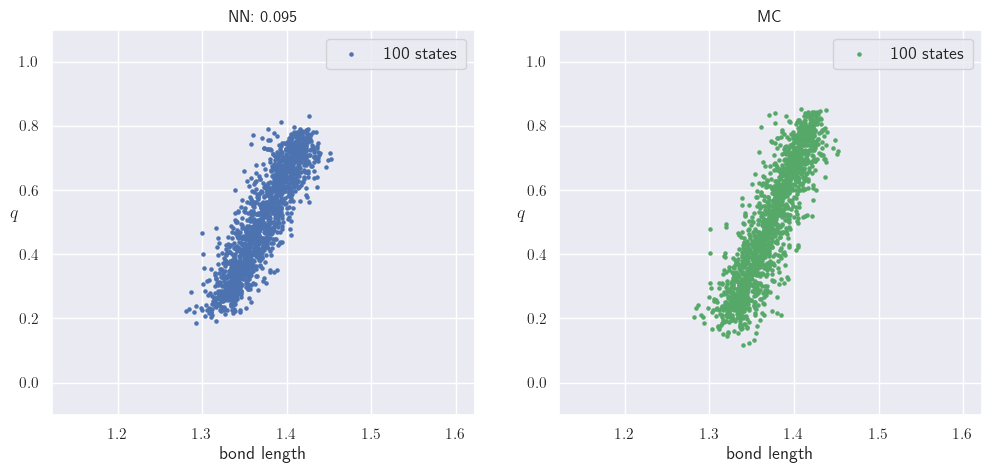

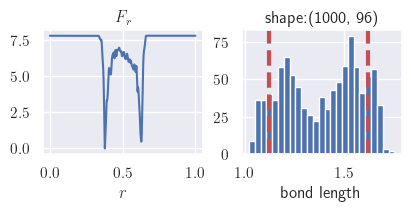

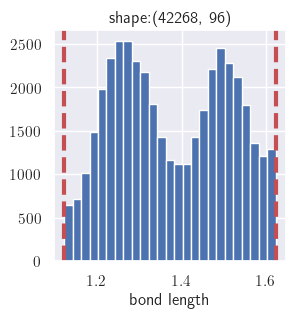

torch.Size([41845, 97]) torch.Size([423, 97])
torch.Size([1980, 96]) torch.Size([20, 96])
torch.Size([1980, 96]) torch.Size([20, 96])
 0k, Loss: -1.00000, -1.00000, Error: 0.09491 0.01167
 0k, Loss: -1.00000, -1.00000, Error: 0.09070 0.01181
 1k, Loss: -1.00000, -1.00000, Error: 0.09840 0.01189
 1k, Loss: -1.00000, -1.00000, Error: 0.11317 0.01125
 2k, Loss: -1.00000, -1.00000, Error: 0.07949 0.01188
 2k, Loss: -1.00000, -1.00000, Error: 0.08955 0.01195
 3k, Loss: -1.00000, -1.00000, Error: 0.08410 0.01162
 3k, Loss: -1.00000, -1.00000, Error: 0.10660 0.01184
 4k, Loss: -1.00000, -1.00000, Error: 0.13123 0.01185
 4k, Loss: -1.00000, -1.00000, Error: 0.09594 0.01176
 5k, Loss: -1.00000, -1.00000, Error: 0.09271 0.01223


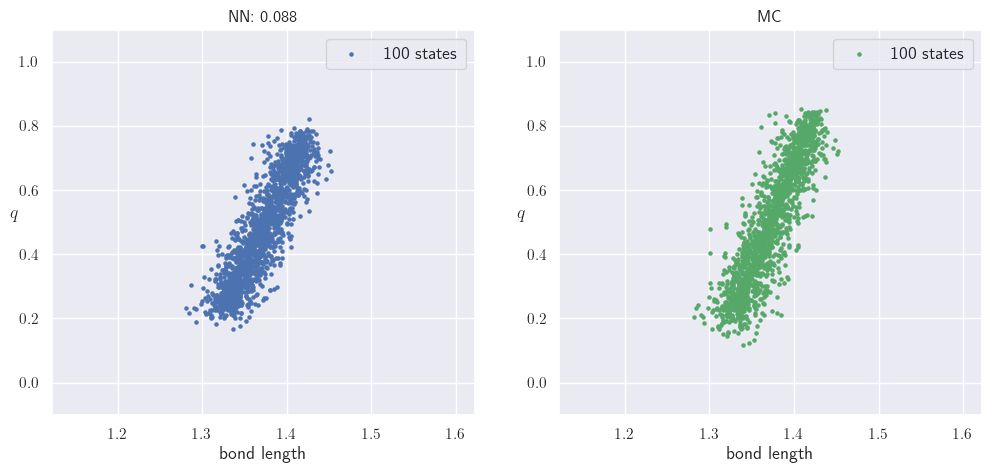

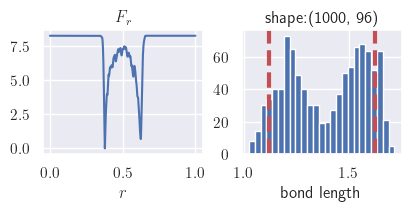

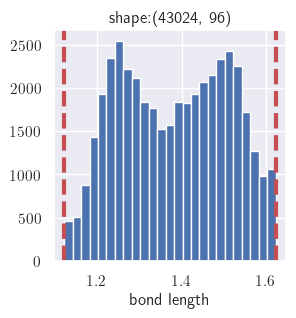

torch.Size([42593, 97]) torch.Size([431, 97])
torch.Size([1980, 96]) torch.Size([20, 96])
torch.Size([1980, 96]) torch.Size([20, 96])
 0k, Loss: -1.00000, -1.00000, Error: 0.08823 0.01217
 0k, Loss: -1.00000, -1.00000, Error: 0.07895 0.01205
 1k, Loss: -1.00000, -1.00000, Error: 0.08341 0.01203
 1k, Loss: -1.00000, -1.00000, Error: 0.08067 0.01188
 2k, Loss: -1.00000, -1.00000, Error: 0.08385 0.01201
 2k, Loss: -1.00000, -1.00000, Error: 0.08054 0.01215
 3k, Loss: -1.00000, -1.00000, Error: 0.09664 0.01183
 3k, Loss: -1.00000, -1.00000, Error: 0.08239 0.01239
 4k, Loss: -1.00000, -1.00000, Error: 0.08544 0.01183
 4k, Loss: -1.00000, -1.00000, Error: 0.08536 0.01216
 5k, Loss: -1.00000, -1.00000, Error: 0.07079 0.01207


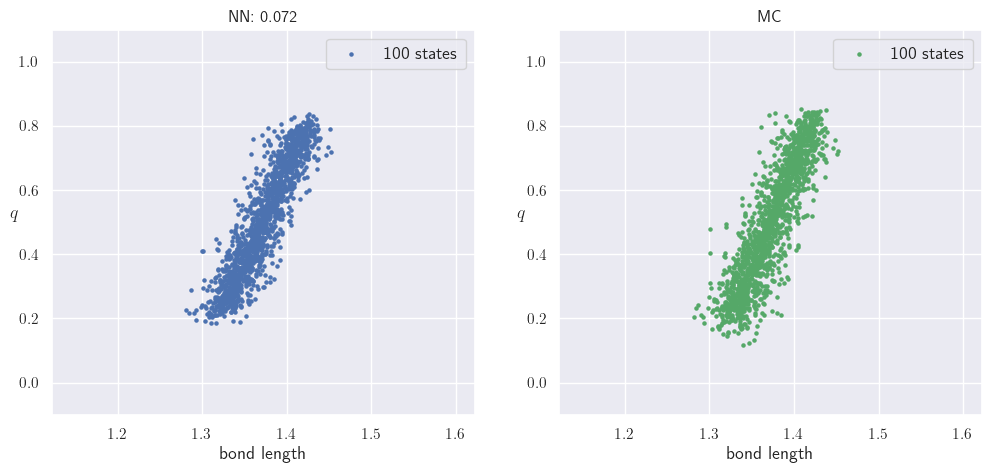

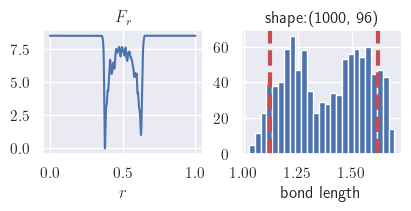

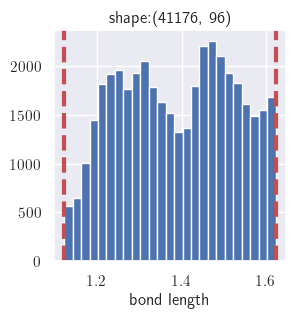

torch.Size([40764, 97]) torch.Size([412, 97])
torch.Size([1980, 96]) torch.Size([20, 96])
torch.Size([1980, 96]) torch.Size([20, 96])
 0k, Loss: -1.00000, -1.00000, Error: 0.07210 0.01208
 0k, Loss: -1.00000, -1.00000, Error: 0.08939 0.01201
 1k, Loss: -1.00000, -1.00000, Error: 0.07514 0.01195
 1k, Loss: -1.00000, -1.00000, Error: 0.08872 0.01174
 2k, Loss: -1.00000, -1.00000, Error: 0.09242 0.01141
 2k, Loss: -1.00000, -1.00000, Error: 0.07599 0.01202
 3k, Loss: -1.00000, -1.00000, Error: 0.07071 0.01203
 3k, Loss: -1.00000, -1.00000, Error: 0.08516 0.01199
 4k, Loss: -1.00000, -1.00000, Error: 0.07168 0.01191
 4k, Loss: -1.00000, -1.00000, Error: 0.11534 0.01179
 5k, Loss: -1.00000, -1.00000, Error: 0.07962 0.01224


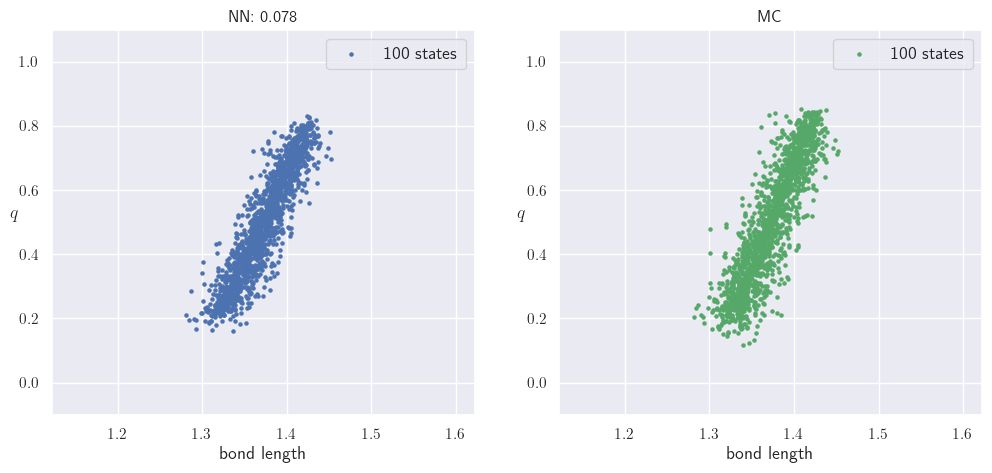

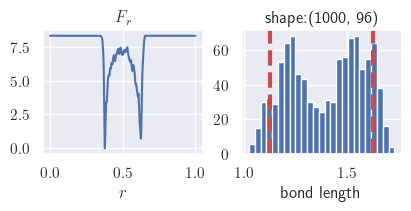

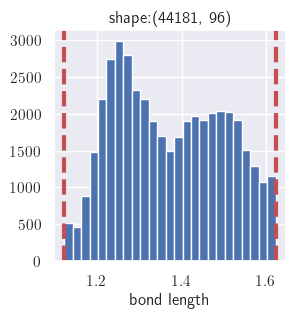

torch.Size([43739, 97]) torch.Size([442, 97])
torch.Size([1980, 96]) torch.Size([20, 96])
torch.Size([1980, 96]) torch.Size([20, 96])
 0k, Loss: -1.00000, -1.00000, Error: 0.07802 0.01223
 0k, Loss: -1.00000, -1.00000, Error: 0.07925 0.01225
 1k, Loss: -1.00000, -1.00000, Error: 0.08662 0.01207
 1k, Loss: -1.00000, -1.00000, Error: 0.08877 0.01214
 2k, Loss: -1.00000, -1.00000, Error: 0.07576 0.01187
 2k, Loss: -1.00000, -1.00000, Error: 0.10181 0.01179
 3k, Loss: -1.00000, -1.00000, Error: 0.11543 0.01188
 3k, Loss: -1.00000, -1.00000, Error: 0.07718 0.01219
 4k, Loss: -1.00000, -1.00000, Error: 0.07360 0.01168
 4k, Loss: -1.00000, -1.00000, Error: 0.07386 0.01193
 5k, Loss: -1.00000, -1.00000, Error: 0.11730 0.01229


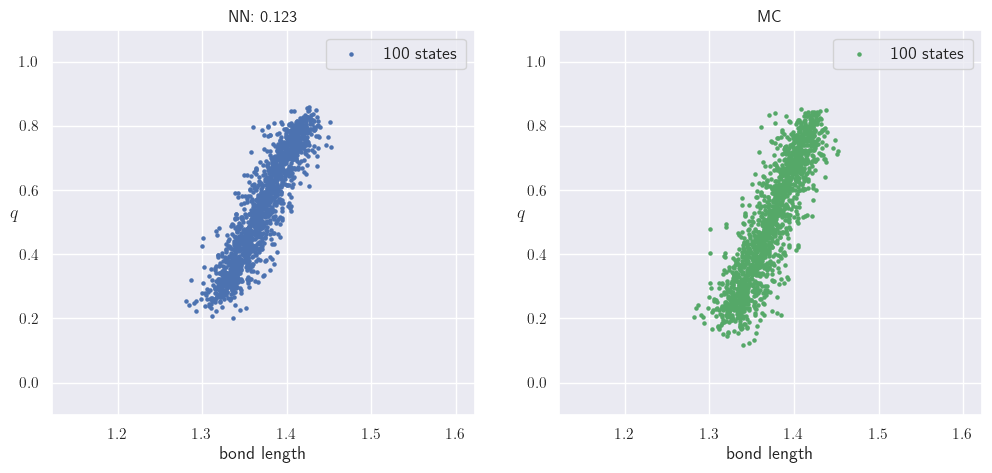

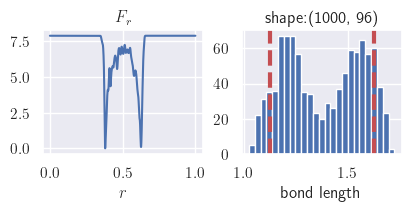

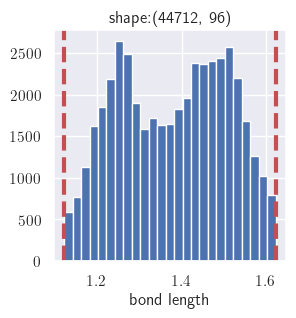

torch.Size([44264, 97]) torch.Size([448, 97])
torch.Size([1980, 96]) torch.Size([20, 96])
torch.Size([1980, 96]) torch.Size([20, 96])
 0k, Loss: -1.00000, -1.00000, Error: 0.12297 0.01234
 0k, Loss: -1.00000, -1.00000, Error: 0.07390 0.01211
 1k, Loss: -1.00000, -1.00000, Error: 0.08165 0.01154
 1k, Loss: -1.00000, -1.00000, Error: 0.07749 0.01177
 2k, Loss: -1.00000, -1.00000, Error: 0.08306 0.01125
 2k, Loss: -1.00000, -1.00000, Error: 0.10388 0.01177
 3k, Loss: -1.00000, -1.00000, Error: 0.07482 0.01212
 3k, Loss: -1.00000, -1.00000, Error: 0.07113 0.01204
 4k, Loss: -1.00000, -1.00000, Error: 0.07522 0.01172
 4k, Loss: -1.00000, -1.00000, Error: 0.09153 0.01218
 5k, Loss: -1.00000, -1.00000, Error: 0.08299 0.01179


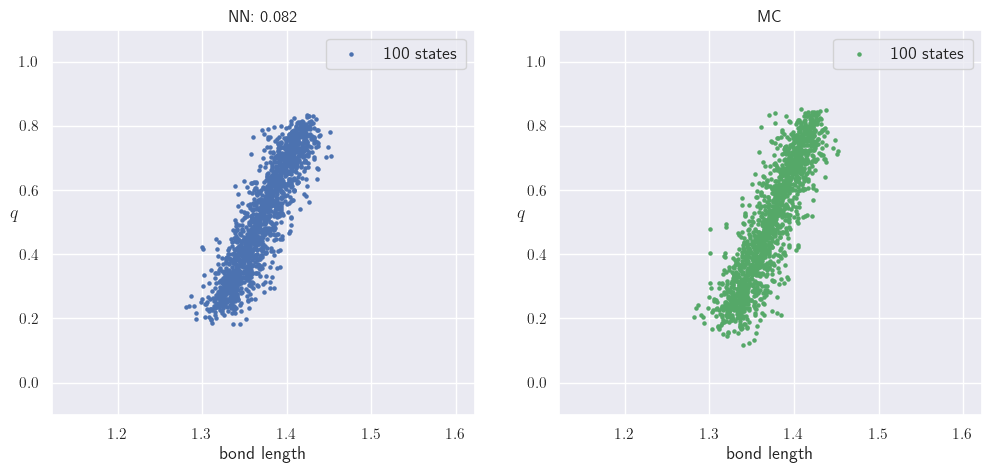

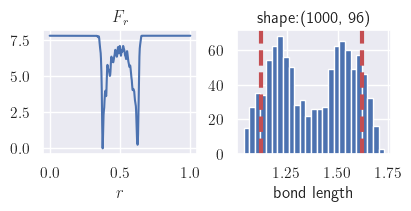

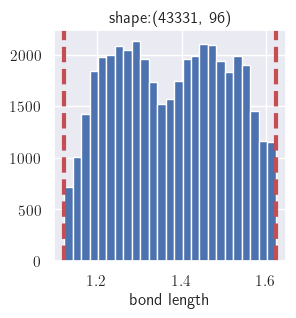

torch.Size([42897, 97]) torch.Size([434, 97])
torch.Size([1980, 96]) torch.Size([20, 96])
torch.Size([1980, 96]) torch.Size([20, 96])
 0k, Loss: -1.00000, -1.00000, Error: 0.08171 0.01180
 0k, Loss: -1.00000, -1.00000, Error: 0.09719 0.01162
 1k, Loss: -1.00000, -1.00000, Error: 0.09500 0.01174
 1k, Loss: -1.00000, -1.00000, Error: 0.12385 0.01217
 2k, Loss: -1.00000, -1.00000, Error: 0.08370 0.01233
 2k, Loss: -1.00000, -1.00000, Error: 0.10088 0.01227
 3k, Loss: -1.00000, -1.00000, Error: 0.07187 0.01222
 3k, Loss: -1.00000, -1.00000, Error: 0.09802 0.01197
 4k, Loss: -1.00000, -1.00000, Error: 0.07354 0.01223
 4k, Loss: -1.00000, -1.00000, Error: 0.07228 0.01206
 5k, Loss: -1.00000, -1.00000, Error: 0.07791 0.01212


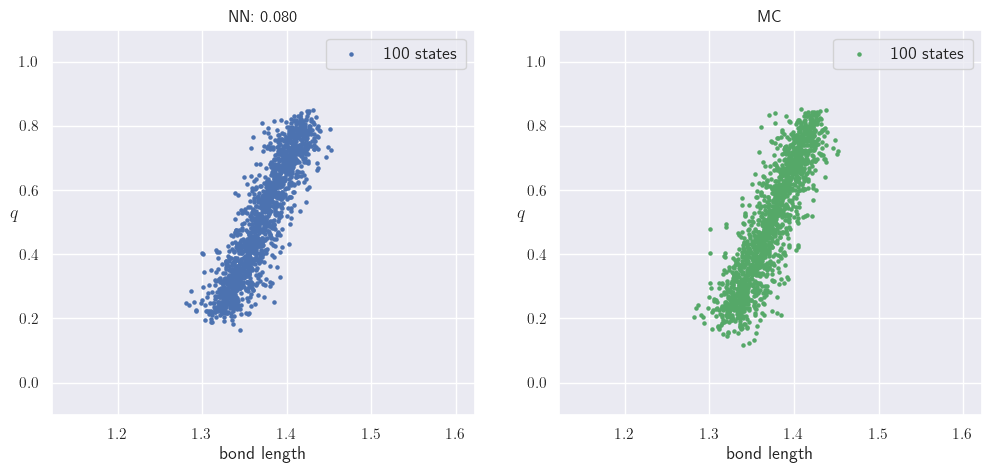

In [16]:
#########     training details  ##########################
c1 = 1;  c2 = 1; learning_rate = 1e-4;                   #
##########################################################

model.load_state_dict(torch.load('../saved_models/E3_Random1'))
torch.save(meta,'../saved_models/'+NAME+'/meta%d'%0)
torch.save(model.state_dict(), '../saved_models/'+NAME+'/par%d'%0)
    
K = 10
for k in range(1,K+1):
    
    meta.re_init()
    meta.perform(dV=SYS.get_dV,x=X_A[-1].reshape(1,-1),dt=1e-4,eps=EPS,
                 N=int(2e5),N_add=200,show_freq=.1,use_tqdm=False,get_x_bc=get_x_bc,show_distr=show_distr,  
                 # may be changed
                 fig_name='../meta_data/'+NAME+'/ite%d'%k)
    meta.show_meta(show_distr)
    
    def get_f(X): return -SYS.get_dV(X) - meta.get_dV(X)
    X0  = np.repeat(X_A[-1].reshape(1,-1),100,axis=0)  
    X   = LI.get_data(X0,get_f,eps=EPS,dt=1e-4,m=100,T0=1,T=6,get_x_bc=get_x_bc,use_tqdm=False);
    X   = down_sample(X)
    fig,ax = plt.subplots(1,1,figsize=(3,3))
    show_distr(X,ax)
    plt.show()
    
    V_add = meta.get_V(X)
    coef  = np.exp(1/EPS*(V_add-V_add.max()))
    coef  = coef/coef.mean()
    
    data_train,data_test = get_train_test(X,coef,X_A,X_B,ratio=.99)
    for i in range(len(data_train)): print(data_train[i].shape,data_test[i].shape)
    optimizer = torch.optim.Adam(model.parameters(),lr=torch.tensor(learning_rate).cuda())
    solver.train_model(data_train=data_train,data_test=data_test,c1=c1,c2=c2,batch_size=100,
                       optimizer=optimizer,n_steps=int(5000+1),n_show_loss=500,use_tqdm=False,
                       error_model1=Error_Model,error_model2=E_AB,)
    Estimate_Model(model)
    
    torch.save(meta,'../saved_models/'+NAME+'/meta%d'%k)
    torch.save([X,coef],'../meta_data/'+NAME+'/data%d'%k)
    torch.save(model.state_dict(), '../saved_models/'+NAME+'/par%d'%k)